In [29]:
import pandas as pd
import numpy as np
import gzip
import io
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import nltk
import nltk.data

from nltk import sentiment
from nltk import word_tokenize
import time
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn import metrics
from w266_common import utils, vocabulary

In [4]:

#Required only once to save data into a pickle file. 

def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)
    
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

home_df = getDF('reviews_Home_and_Kitchen.json.gz')    

In [2]:
#Reading back from the pickle file
start =time.time()
home_df = pd.read_pickle('./home_df.pkl')
stop = time.time()
print(stop-start)

111.9645459651947


In [10]:
print(home_df.shape)
home_df.dtypes

(4253926, 9)


reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object

In [18]:
home_df.tail()
#summary field would be an interesting field to explore. Seems like a user entered field.
#another one would be helpful field. This is in list form.
#Also see if the length of review text is correlated with more positive or negative review.

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
4253921,AF30DHAVSYNZ0,B00LXFP8NK,Sasha DLH,"[0, 0]",Another cute set from this company that I must...,5.0,Cute,1405641600,"07 18, 2014"
4253922,A34KTJ4VWNBOHI,B00LXFP8NK,Stina,"[0, 0]","With a little girl who loves pink, this was th...",5.0,Lovely Set for Girls,1405900800,"07 21, 2014"
4253923,A4XPE5UGK51IA,B00LXFP8NK,Tia Scott,"[0, 0]",My cousin bought this one for her daughter and...,5.0,Fun Colors & Patterns,1405900800,"07 21, 2014"
4253924,A2LUDC2DWHMRDA,B00M0U03EQ,Felicia Rego,"[0, 0]",This desk is better then the last two I had in...,5.0,Sturdy and Reliable,1405987200,"07 22, 2014"
4253925,ADL558O3IM9DY,B00M0U03EQ,Richard Bourbeau,"[0, 0]",I have had this desk for about a month. It is ...,5.0,Small but heavy!,1405987200,"07 22, 2014"


In [14]:
home_df.overall.describe()

count    4.253926e+06
mean     4.099486e+00
std      1.331712e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

In [36]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4253926 entries, 0 to 4253925
Data columns (total 10 columns):
reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall           float64
summary           object
unixReviewTime    int64
reviewTime        object
polarity          int64
dtypes: float64(1), int64(2), object(7)
memory usage: 357.0+ MB


In [40]:
#checking for null values
home_df.isnull().sum()
#Only reviewerName has 33202 null values.Since this field is not being used in the analysis we 
#leave these rows in the dataframe

reviewerID            0
asin                  0
reviewerName      33202
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
polarity              0
dtype: int64

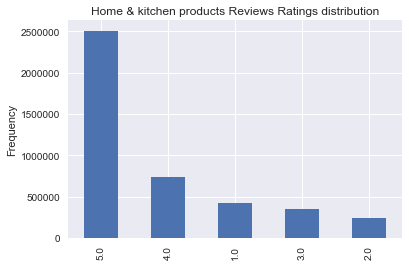

In [23]:

home_df['overall'].value_counts().plot(kind='bar')
plt.title("Home & kitchen products Reviews Ratings distribution")
plt.ylabel("Frequency")

In [ ]:
# Convert 5 types ratings into 2 (negative or positive with value 0 and 1 respectively)
home_df["polarity"] = np.where(home_df['overall'] > 3, 1, 0)
home_df.tail()

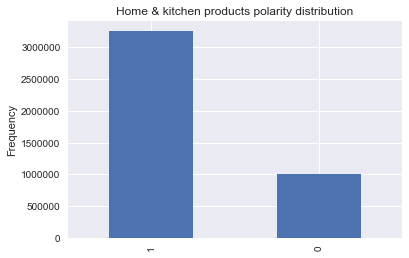

In [24]:
home_df['polarity'].value_counts().plot(kind='bar')
plt.title("Home & kitchen products polarity distribution")
plt.ylabel("Frequency")
#Still see a haeavy positive skew with only about 25% of the polarity as negative. So this dtaset is highly imbalanced

In [28]:
#Saving the df with polarity field into  pickle file
start =time.time()
home_df.to_pickle('./home_df.pkl')
stop = time.time()
print(stop-start)

182.42838525772095


In [6]:
#working with a small subset of data
working_df = home_df[0:1000]
working_df.tail()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,polarity
995,A1Q2OH58I3LNZI,1574890832,S. Camburides,"[0, 0]",I really enjoy Cavallini products and the imag...,1.0,"Beautiful designs, very weak magnets",1396137600,"03 30, 2014",0
996,A383UPUHY7V0V1,1574891898,Art,"[2, 3]",I have seen this same image for much more on p...,5.0,Great poster substitute,1370304000,"06 4, 2013",1
997,A3MXHFXM8751RG,1574891898,Graham McHardy,"[0, 0]",Just what I needed as an unusual and appropria...,5.0,Perfect as a small gift for a Francophile,1357776000,"01 10, 2013",1
998,A37DCA81R345BY,1574891898,Hoshikimi,"[2, 2]",Originally saw this on urban outfitters for 5 ...,5.0,Sooo cool,1336694400,"05 11, 2012",1
999,A1AJ7KD5QKX8TS,1574891898,JT,"[1, 2]","Love the colors, the paper stock, and the beau...",5.0,Just what I was hoping for!,1287360000,"10 18, 2010",1


In [7]:
#Subset the data into training and test
X_train, X_test, y_train, y_test = train_test_split(working_df['reviewText'], 
                                                    #working_df['overall'],
                                                    working_df['polarity'],
                                                    test_size=.2, random_state=1)

In [37]:
# instantiate the vectorizer

vect = CountVectorizer()

# tokenize train and test text data
X_train_features = vect.fit_transform(X_train)
print("number words in training corpus:", len(vect.get_feature_names()))
X_test_features = vect.transform(X_test)
print(X_train[0:4])

number words in training corpus: 4270
382    I'm new to cake decorating and I love this boo...
994    Great magnets! They are good quality and look ...
982    GREAT. IT SURE HELPS A LOT, I DON'T KNOW WHAT ...
47     Im an intermediate cake decorator. I bought th...
Name: reviewText, dtype: object


In [32]:
print(X_train_features[2])

  (0, 2613)	1
  (0, 2634)	1
  (0, 3405)	1
  (0, 83)	1
  (0, 3779)	1
  (0, 2693)	1
  (0, 4187)	1
  (0, 1285)	1
  (0, 4201)	1
  (0, 4141)	1
  (0, 2188)	1
  (0, 1282)	1
  (0, 2335)	1
  (0, 1907)	1
  (0, 3694)	1
  (0, 1802)	1
  (0, 2132)	3


In [27]:
#Top 20 occuring words in the reviewtext field in the dataset

word_frequency = np.asarray(X_train_features.sum(axis=0)).ravel()
print('train', word_frequency.shape)
#use argsort to get the index and then get the words with top 20 frequency.

for n in range(-20, 0):
    pos = word_frequency.argsort()[n]
    print('pos ', pos,'word_frequency', word_frequency[pos], vect.get_feature_names()[pos])
    
#We see that the top words are common prepositions etc)    

train (4270,)
pos  2653 word_frequency 291 on
pos  284 word_frequency 291 as
pos  1877 word_frequency 303 have
pos  577 word_frequency 314 but
pos  267 word_frequency 323 are
pos  4187 word_frequency 329 with
pos  4096 word_frequency 334 was
pos  3778 word_frequency 369 that
pos  2545 word_frequency 374 my
pos  4257 word_frequency 381 you
pos  2031 word_frequency 455 in
pos  469 word_frequency 645 book
pos  2633 word_frequency 671 of
pos  2126 word_frequency 692 is
pos  1645 word_frequency 779 for
pos  3807 word_frequency 828 this
pos  3857 word_frequency 1148 to
pos  2132 word_frequency 1157 it
pos  209 word_frequency 1257 and
pos  3780 word_frequency 1834 the


In [21]:
# We use the tfid to give weigthage to words occuring more frequently. At the same time, to get 
#rid of prepositions which are not helping with context, we use stop words.
tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.8, stop_words='english')
tfidf_train_1 = tfidf_vect.fit_transform(X_train)
tfidf_test_1 = tfidf_vect.transform(X_test)

/Users/anamika/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [22]:
word_frequency = np.asarray(tfidf_train_1.sum(axis=0)).ravel()
print('train', word_frequency.shape)
#use argsort to get the index and then get the words with top 20 frequency.

for n in range(-20, 0):
    pos = word_frequency.argsort()[n]
    print('pos ', pos,'word_frequency', word_frequency[pos], tfidf_vect.get_feature_names()[pos])

train (676,)
pos  239 word_frequency 13.535612479590249 gift
pos  308 word_frequency 13.874662126405356 instructions
pos  463 word_frequency 13.905432440014547 product
pos  553 word_frequency 13.908141869013665 spelling
pos  654 word_frequency 14.646462781618956 wilton
pos  364 word_frequency 15.286792860192815 make
pos  72 word_frequency 15.745477161586983 cakes
pos  58 word_frequency 17.459173904465263 bought
pos  290 word_frequency 18.094065176895395 ideas
pos  480 word_frequency 19.500607711879496 really
pos  178 word_frequency 19.591919753772206 easy
pos  358 word_frequency 21.035591410376274 love
pos  342 word_frequency 21.757698355711774 like
pos  318 word_frequency 22.053427437692026 just
pos  147 word_frequency 22.602648466185407 decorating
pos  626 word_frequency 22.670453373127444 use
pos  249 word_frequency 26.2576721060193 good
pos  71 word_frequency 27.203512024070754 cake
pos  254 word_frequency 30.47020262162768 great
pos  55 word_frequency 59.417428309165665 book


In [40]:
# instantiate and train model, kernel=rbf 

svm_model = svm.SVC(kernel='rbf')
start =time.time()

svm_model.fit(tfidf_train_1, y_train)

# evaulate model
y_pred_1 = svm_model.predict(tfidf_test_1)

target_names = ['polarity 0', 'polarity 1']
print(classification_report(y_test, y_pred_1, target_names=target_names))
stop = time.time()
print(stop-start)

#Does not look like the negative class is correct. Is it because of highly unbalanced negative class.
#Lookup http://scikit-learn.org/stable/modules/svm.html#unbalanced-problems

             precision    recall  f1-score   support

 polarity 0       0.00      0.00      0.00        39
 polarity 1       0.81      1.00      0.89       161

avg / total       0.65      0.81      0.72       200

0.19898319244384766


/Users/anamika/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:

from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
x_tokens = tokenizer.tokenize(X_train)
x_tokens=